In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import random
import os

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense,Dropout, LeakyReLU
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.glove_word_embedding_generator import GloveWordEmbeddingGenerator
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.metrics import rmse
from lib.model.search.greedy_search_strategy import GreedySearchStrategy
from lib.model.search.beam_search_strategy import BeamSearchStrategy, EndCriteria
from lib.model.attention_layer import AttentionLayer

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory
from lib.utils.plot_utils import PredictionInspector, show_sample
from lib.utils.array_utils import column
from lib.utils.pickle_utils import save_obj, load_obj
from lib.utils.sequencer import Sequencer

from keras.callbacks                         import ModelCheckpoint
from lib.callback.metric_plotter             import MetricsPlotter
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker
from keras.callbacks                         import ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
dataset_name='8k'
# dataset_name='30k'

embedding_vector_dim = 300
embedding_token_count = 6
embedding_token_count = 840
embeding_name = f'{embedding_token_count}B.{embedding_vector_dim}d'
word_embedding_path = f'./dataset/glove.{embeding_name}.txt'



dataset_path=f'./dataset/{dataset_name}'
data_path = f'{dataset_path}/data'
images_path = f'{dataset_path}/images'

image_features_path = f'{dataset_path}/img_features.pkl'
descrption_embedding_path = f'{dataset_path}/descrition_embeding.{embeding_name}.pkl'

line_separator = { 
    '8k': r'#[0-9]',
    '30k': r'\| [0-9]\|'
}
weights_path = create_directory(f'weights/{dataset_name}')
weights_file_path_patern = weights_path + '/weights__epoch_{epoch:02d}__loss_{val_loss:.4f}__acc_{val_rmse:.4f}.h5'

In [4]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True,
    separator=line_separator[dataset_name]
)

Max len desc: $ an africanamerican man wear green sweatshirt and blue vest be hold up dollar bill in front of his face while stand on busy sidewalk in front of group of man play instrument #


In [5]:
train_samples, remain_samples = train_test_split(dataset.samples(), test_size=0.16, shuffle=True)
val_samples, test_samples = train_test_split(remain_samples, test_size=0.22, shuffle=True)

print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 6796, Val: 1010, Test: 285


In [6]:
save_obj(f'{dataset_path}/train_samples.pkl', train_samples)
save_obj(f'{dataset_path}/val_samples.pkl', val_samples)
save_obj(f'{dataset_path}/test_samples.pkl', test_samples)

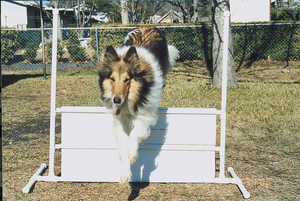

,Description
0,border collie be outside jump over an obstacle
1,collie jump over white obstacle
2,collie jump hurdle
3,collie jump over white agility jump
4,dog jump over hurdle in the grass


In [7]:
show_sample(train_samples[0])

In [8]:
if not os.path.isfile(image_features_path):
    image_paths = dataset.samples(col=0)
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    save_obj(image_features_path, image_features)

image_features = load_obj(image_features_path)
print(image_features[0])
image_features = dict(image_features)

('./dataset/8k/images/1305564994_00513f9a5b.jpg', array([ 0.06508789,  0.03218704,  0.02376981, ...,  0.38368699,
        0.19910596,  0.23510453], dtype=float32))


In [9]:
min_occurs=10
vocabulary = dataset.words_set(min_occurs=10)
vocabulary_size = len(vocabulary)
complete_vocabulary_size = len(dataset.words_set())
print(f'Words(occurs>={min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1593/6688


In [10]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

In [11]:
len(word_to_index)

1593

In [12]:
dataset.max_desc_len()

174

In [13]:
if not os.path.isfile(descrption_embedding_path):
    embedding_generator = GloveWordEmbeddingGenerator(word_embedding_path, embedding_vector_dim)
    embedding_matrix = embedding_generator.generate(word_to_index)
    save_obj(descrption_embedding_path, embedding_matrix)

embedding_matrix = load_obj(descrption_embedding_path)
len(embedding_matrix)

1593

In [14]:
def build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, optimizer):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))

    img_branch = Dropout(0.5)(img_feat_input)
    img_branch = Dense(512)(img_branch)
    img_branch = LeakyReLU(alpha=0.3)(img_branch)

    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))

    seq_branch = Embedding(vocabulary_size, embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(0.5)(seq_branch)
    seq_branch = LSTM(512)(seq_branch)

    decoder = add([img_branch, seq_branch])
    decoder = Dense(512)(decoder)
    decoder = LeakyReLU(alpha=0.3)(decoder)
    
    outputs = Dense(name="Words_Distribution", units=vocabulary_size, activation='softmax')(decoder)

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)

    model.layers[3].set_weights([embedding_matrix])
    model.layers[3].trainable = False

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=[rmse]
    )

    return ModelWrapper(model)

In [32]:
epochs=12
batch_size = 16
# lr=0.001
lr=0.00004 # Epoch 10
steps_per_epoch=len(train_samples)/batch_size

In [33]:
train_generator = DataGenerator(
    train_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

val_generator = DataGenerator(
    val_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

In [34]:
callbacks = [
    ModelCheckpoint(
        weights_file_path_patern,
        monitor='val_loss', 
        verbose=1,
        save_best_only=True, 
        save_weights_only=True, 
        mode='auto',
        period=1
    ),
    AdamLearningRateTracker(evaluate_interval=105),
    ReduceLROnPlateau(
        monitor  = 'val_loss',
        factor   = 0.2,
        patience = 1
    ),
    MetricsPlotter(
        val_generator, 
        plot_interval=500, 
        evaluate_interval=500, 
        batch_size=batch_size
    )
#,
#    LRScheduler(
#        { 
#            0: 0.001, 
#            6: 0.0001
#            12: 0.00001
#        }, 
#        verbose=1
#    )
]

In [35]:
model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, Adam(lr=lr))
# model.show()    

In [38]:
# model.load(f'{weights_path}/weights__epoch_12__loss_2.9826__acc_0.0221.h5')

model.load(f'{weights_path}/weights__epoch_01__loss_2.2551__acc_0.0208.h5')
# model.fit(train_generator, val_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

Load weights from weights/8k/weights__epoch_01__loss_2.2551__acc_0.0208.h5


In [39]:
sequencer = Sequencer(
    word_to_index=word_to_index,
    index_to_word=index_to_word,
    max_seq_len=dataset.max_desc_len()
)

search = BeamSearchStrategy(
    model=model,
    sequencer=sequencer,
    seq_prefix='$',
    seq_postfix='#',
    end_criteria=EndCriteria().at_lest_n_end_with(n=10, word='#'),
    k=10
)

def random_sample(samples): return samples[random.randint(0, len(samples)-1)]

inspector = PredictionInspector(search, image_features)

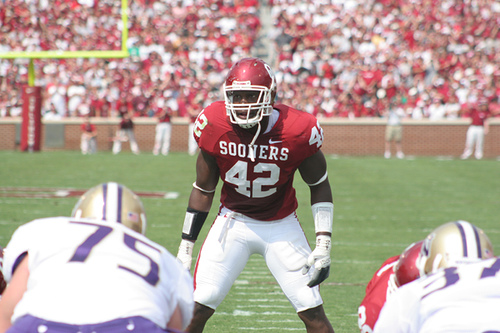

,Description
0,football layer wear red shirt
1,football player face off against two others
2,football player for the sooner stand in front of the oppsing team wait for the next play
3,football player in red uniform be stand in front of other football player in stadium
4,defensive player wait for the snap


,Predicted description,Score
0,football player prepare to throw the ball during game,0.0000016807
1,football player prepare to throw the ball during game during game,0.0000033079
2,football player prepare to throw the ball during game game,0.0000191578


In [44]:
inspector.inspect(random_sample(test_samples))

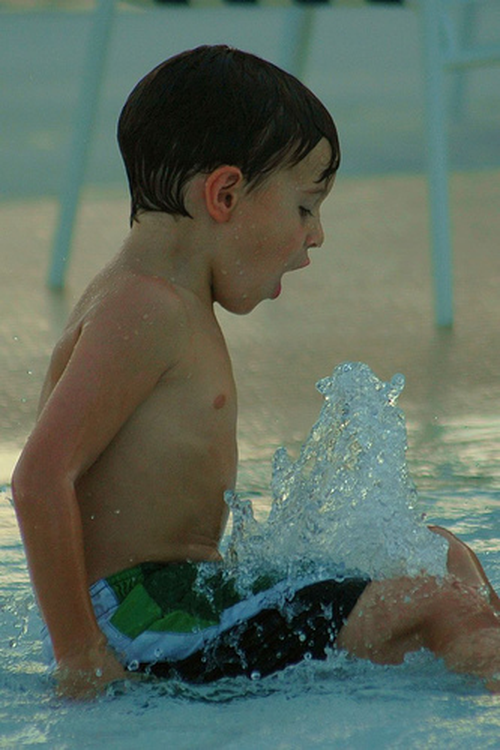

,Description
0,boy sit in water
1,small boy be sit in the water and water be splash up through his leg
2,young boy in swim suit sit in water
3,young boy sit on water jet in pool
4,little boy sit in water with fountain come up through his lap


,Predicted description,Score
0,boy in swim trunk play in pool,0.0079990576
1,boy in swim trunk play in water,0.0163033298
2,little boy in swim trunk play in pool,0.0256231956


In [41]:
inspector.inspect(random_sample(test_samples))

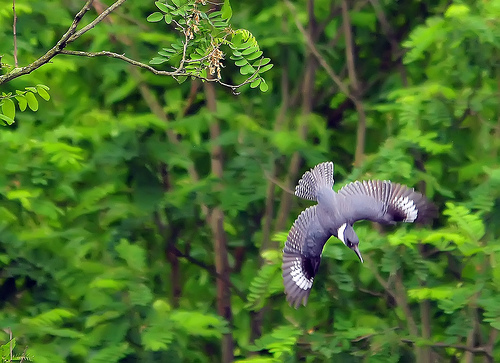

,Description
0,black bird be in midflight swoop downwards
1,blue bird fly toward the ground surround by tree
2,blue bird be fly through tree
3,gray bird be fly through tree
4,greyblue bird with white marking on neck and wings in flight


,Predicted description,Score
0,bird fly through the air in front of tree,0.0000002078
1,bird fly through the air in front of group of person,0.0000003146
2,bird fly through the air in front of group of plant,0.0000004523


In [42]:
inspector.inspect(random_sample(test_samples))

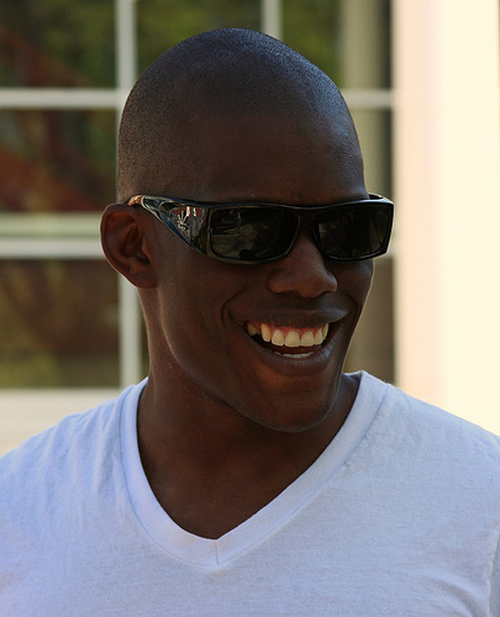

,Description
0,an african american in sunglasses and white teeshirt smile
1,young black man in sunglasses be smile broadly
2,young man wear dark sunglasses smile
3,smile bald black man in sunglasses and tshirt
4,smile black man be wear white tshirt and dark sunglasses


,Predicted description,Score
0,bald man wear sunglasses and sunglasses look at the camera,0.0007374278
1,bald man wear sunglasses and sunglasses in front of an,0.0010084813
2,bald man wear sunglasses and sunglasses in front of white,0.0010684780


In [43]:
inspector.inspect(random_sample(test_samples))